/var/folders/pf/2wxkf2nx2nz2_y55fmyz8cn40000gn/T/ipykernel_46655/26912753.py:197: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKERS, start=FETCH_START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed

Fetching data for ['SPY', '^TNX'] from 2022-01-01 to 2025-11-25...
Data loaded successfully. Calculating signals...

--- Diagnostic Breakdown ---
Total Analysis Days: 477
TVF < 0 (Vola Contraction): 57 days
Yield < 5D Avg (Cheap Yield): 226 days
Buy Signal requires BOTH: 24 days
--------------------
TVF > 0 (Vola Expansion): 420 days
Yield > 5D Avg (Expensive Yield): 251 days
Sell Signal requires BOTH: 218 days
---

--- Signal Summary ---
Analysis Period: 2024-01-01 to 2025-11-24
Buy Signals Generated: 24
Sell Signals Generated: 218
---


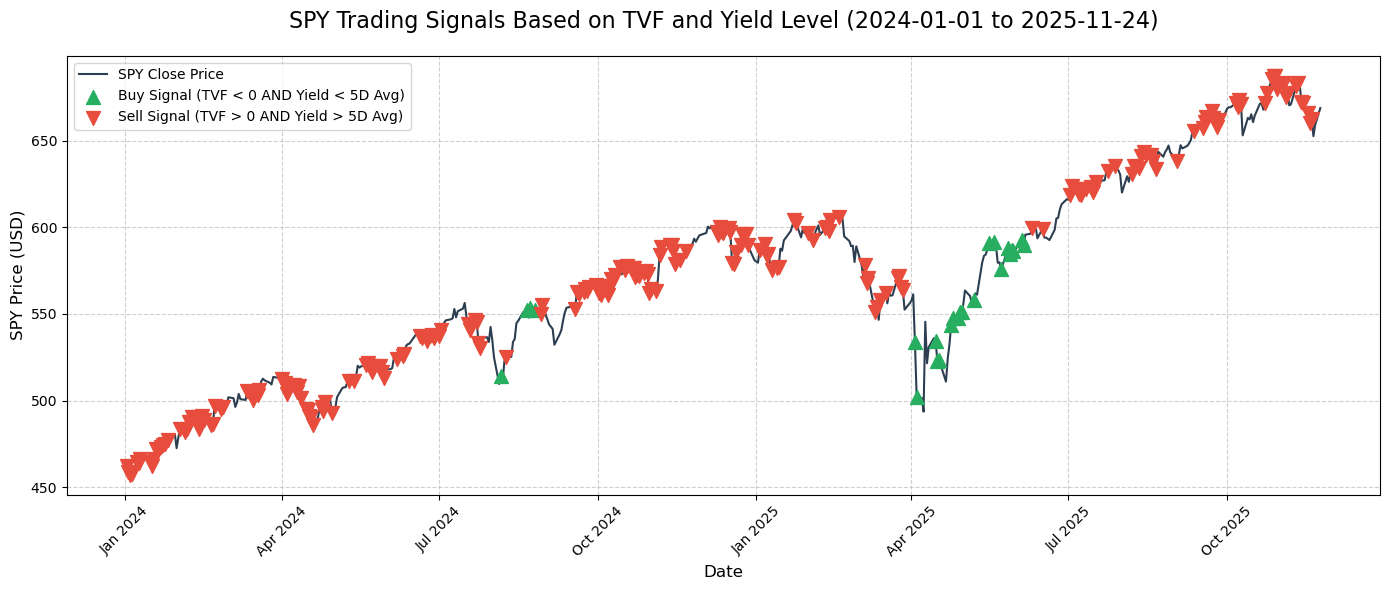

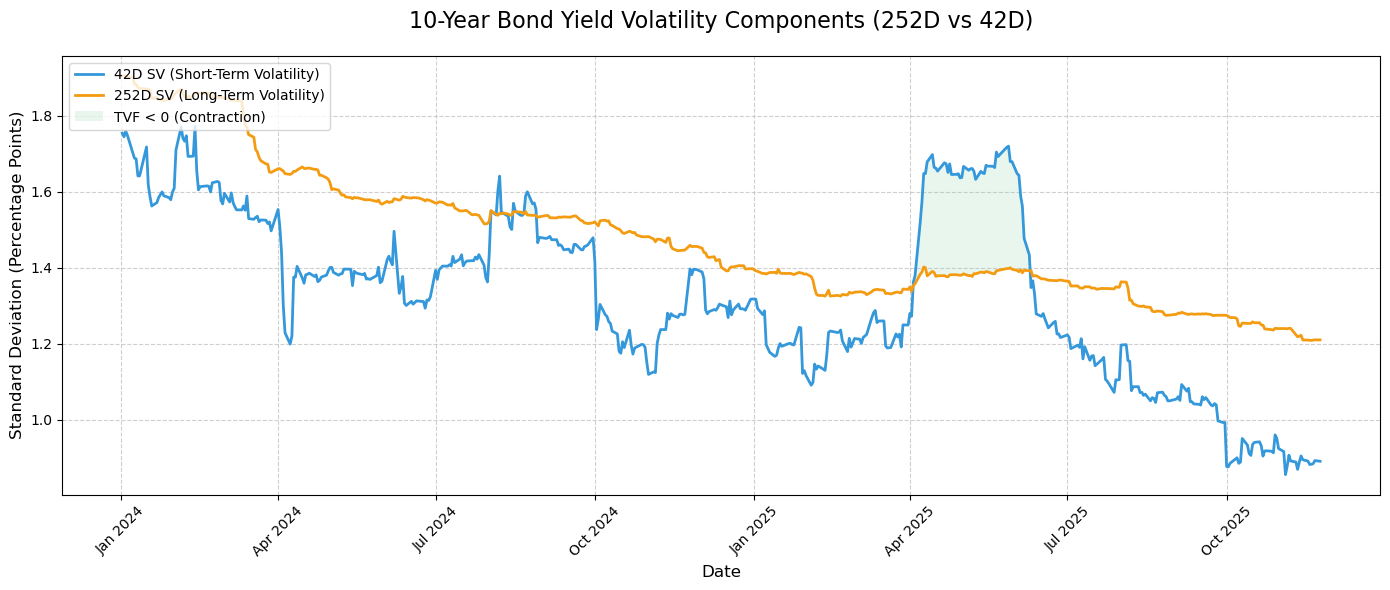

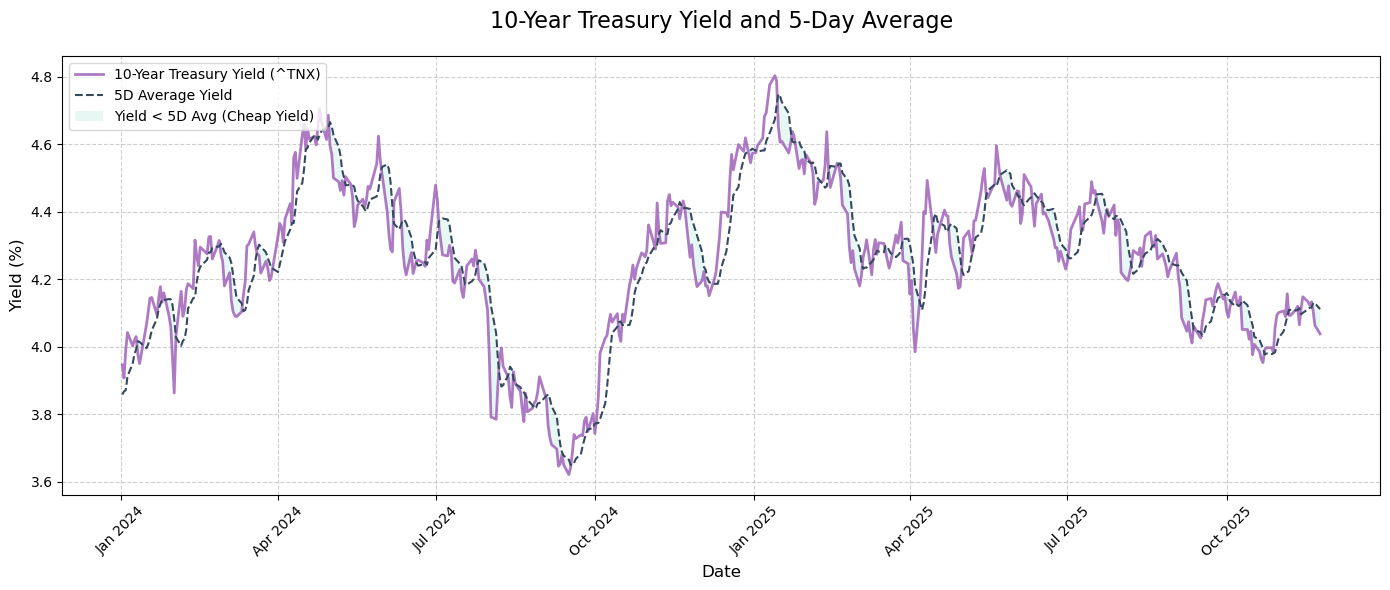

In [58]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from datetime import timedelta

# --- 1. CONFIGURATION ---

# The ticker for the assets to analyze
TICKERS = ['SPY', '^TNX']

# --- SET YOUR DESIRED ANALYSIS PERIOD HERE ---
ANALYSIS_START_DATE_STR = '2024-01-01'
END_DATE = pd.to_datetime('2025-11-25').strftime('%Y-%m-%d')

# Lookback periods in trading days (approx. 21 trading days per month):
PERIOD_LONG_DAYS = 252   # Approx 12 months * 21 trading days/month
PERIOD_SHORT_DAYS = 42   # Approx 2 months * 21 trading days/month
PERIOD_AVG_YIELD = 5     # Last week's average yield (5 trading days)

# Calculate the required FETCH_START_DATE to ensure the longest rolling window (252 days) is valid
ANALYSIS_START_DATE = pd.to_datetime(ANALYSIS_START_DATE_STR)
# We subtract 2 calendar years for a safe historical buffer
FETCH_START_DATE = (ANALYSIS_START_DATE - timedelta(days=2 * 365)).strftime('%Y-%m-%d')

def calculate_tvf_signals(data):
    """
    Calculates the Treasury Volatility Formula (TVF) and generates Buy/Sell signals
    based on the combined condition: Volatility + Yield Level.

    Buy Signal: TVF < 0 AND Observed Yield < 5-day Avg Yield
    Sell Signal: TVF > 0 AND Observed Yield > 5-day Avg Yield
    """
    # Step 1: Extract the 10-Year Treasury Yield data
    tnx_yield = data['TNX_Close']

    # Step 2: Calculate Daily Yield Change (the input for volatility)
    tnx_daily_change = tnx_yield.pct_change() * 100

    # Step 3: Calculate Rolling Standard Deviations (the SV values requested)
    vol_long = tnx_daily_change.rolling(window=PERIOD_LONG_DAYS).std()
    vol_short = tnx_daily_change.rolling(window=PERIOD_SHORT_DAYS).std()

    # Step 4: Calculate Treasury Volatility Formula (TVF)
    data['TVF'] = vol_long - vol_short
    data['Vol_Long'] = vol_long
    data['Vol_Short'] = vol_short

    # Step 5: Calculate Last Week's Average Yield and Observed Yield
    # Shift(1) avoids lookahead bias by using the average up to the *previous* day
    data['Avg_Yield_5D'] = tnx_yield.rolling(window=PERIOD_AVG_YIELD).mean().shift(1)
    data['Observed_Yield'] = tnx_yield

    # Filter data: Drop initial rows where rolling windows aren't fully formed
    data = data.dropna(subset=['TVF', 'Avg_Yield_5D'])
    
    # Slice to the requested analysis period
    data = data.loc[data.index >= ANALYSIS_START_DATE]

    # --- Diagnostic Columns for Counting ---
    data['TVF_Contracting'] = data['TVF'] < 0
    data['TVF_Expanding'] = data['TVF'] > 0
    data['Yield_Cheap'] = data['Observed_Yield'] < data['Avg_Yield_5D']
    data['Yield_Expensive'] = data['Observed_Yield'] > data['Avg_Yield_5D']

    # Step 6: Generate Signals (Combined Conditions)
    data['Signal'] = 0 # Default to no signal

    # Buy Signal Logic
    buy_condition = data['TVF_Contracting'] & data['Yield_Cheap']
    data.loc[buy_condition, 'Signal'] = 1  # 1 for Buy

    # Sell Signal Logic
    sell_condition = data['TVF_Expanding'] & data['Yield_Expensive']
    data.loc[sell_condition, 'Signal'] = -1 # -1 for Sell

    # Return all necessary data for plotting and diagnostics
    signals_df = data[['SPY_Close', 'TNX_Close', 'Observed_Yield', 'Avg_Yield_5D', 
                       'TVF', 'Vol_Long', 'Vol_Short', 'Signal', 
                       'TVF_Contracting', 'Yield_Cheap', 'TVF_Expanding', 'Yield_Expensive']]
    
    return signals_df

def plot_signals(df):
    """
    Plots the SPY closing price with Buy and Sell signals overlaid.
    """
    if df.empty:
        print("Error: No data remains after filtering.")
        return

    spy_prices = df['SPY_Close']
    buy_signals = df[df['Signal'] == 1]
    sell_signals = df[df['Signal'] == -1]
    
    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot SPY Prices
    ax.plot(spy_prices.index, spy_prices.values, label='SPY Close Price', color='#2c3e50', linewidth=1.5)

    # Plot Buy Signals
    ax.scatter(buy_signals.index, spy_prices.loc[buy_signals.index],
               marker='^', color='#27ae60', s=100, label='Buy Signal (TVF < 0 AND Yield < 5D Avg)', alpha=1.0, zorder=5)

    # Plot Sell Signals
    ax.scatter(sell_signals.index, spy_prices.loc[sell_signals.index],
               marker='v', color='#e74c3c', s=100, label='Sell Signal (TVF > 0 AND Yield > 5D Avg)', alpha=1.0, zorder=5)

    # Styling and Labels
    ax.set_title(f'SPY Trading Signals Based on TVF and Yield Level ({ANALYSIS_START_DATE_STR} to {df.index[-1].strftime("%Y-%m-%d")})', fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('SPY Price (USD)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left', fontsize=10)

    # Format the x-axis for better date readability
    date_form = DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()

def plot_volatility_components(df):
    """
    Plots the 252-day and 42-day standard deviations of the 10-Year Bond Yield.
    """
    if df.empty:
        return

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot the 42-day (short-term) Volatility
    ax.plot(df.index, df['Vol_Short'], label=f'{PERIOD_SHORT_DAYS}D SV (Short-Term Volatility)', color='#3498db', linewidth=2)

    # Plot the 252-day (long-term) Volatility
    ax.plot(df.index, df['Vol_Long'], label=f'{PERIOD_LONG_DAYS}D SV (Long-Term Volatility)', color='#f39c12', linewidth=2)

    # Highlight when TVF is negative (Vol_Short > Vol_Long -> Volatility Contraction)
    ax.fill_between(df.index, df['Vol_Short'], df['Vol_Long'], 
                    where=(df['Vol_Short'] > df['Vol_Long']), 
                    facecolor='#27ae60', alpha=0.1, interpolate=True, label='TVF < 0 (Contraction)')
    
    # Styling and Labels
    ax.set_title(f'10-Year Bond Yield Volatility Components ({PERIOD_LONG_DAYS}D vs {PERIOD_SHORT_DAYS}D)', fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Standard Deviation (Percentage Points)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left', fontsize=10)

    # Format the x-axis for better date readability
    date_form = DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()

def plot_yield_movement(df):
    """
    Plots the raw 10-year yield movement and its 5-day average.
    """
    if df.empty:
        return

    fig, ax = plt.subplots(figsize=(14, 6))

    # Plot the 10-Year Treasury Yield (Observed Yield)
    ax.plot(df.index, df['Observed_Yield'], label='10-Year Treasury Yield (^TNX)', color='#9b59b6', linewidth=2, alpha=0.8)

    # Plot the 5-Day Average Yield
    ax.plot(df.index, df['Avg_Yield_5D'], label=f'{PERIOD_AVG_YIELD}D Average Yield', color='#34495e', linewidth=1.5, linestyle='--')
    
    # Highlight the Buy/Sell condition
    # Highlight regions where Observed Yield is below the average (Yield_Cheap)
    ax.fill_between(df.index, df['Observed_Yield'], df['Avg_Yield_5D'], 
                    where=(df['Observed_Yield'] < df['Avg_Yield_5D']), 
                    facecolor='#1abc9c', alpha=0.1, interpolate=True, label='Yield < 5D Avg (Cheap Yield)')

    # Styling and Labels
    ax.set_title('10-Year Treasury Yield and 5-Day Average', fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Yield (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='upper left', fontsize=10)

    # Format the x-axis for better date readability
    date_form = DateFormatter("%b %Y")
    ax.xaxis.set_major_formatter(date_form)
    plt.xticks(rotation=45)
    plt.tight_layout()


# --- 2. MAIN EXECUTION ---
if __name__ == '__main__':
    print(f"Fetching data for {TICKERS} from {FETCH_START_DATE} to {END_DATE}...")

    try:
        # Fetch data using yfinance
        raw_data = yf.download(TICKERS, start=FETCH_START_DATE, end=END_DATE)
        if raw_data.empty:
            print("Error: Could not retrieve data. Check tickers and date range.")
        else:
            # Simplify the DataFrame structure by extracting only the 'Close' prices
            df = raw_data['Close'].copy()
            df = df.rename(columns={'^TNX': 'TNX_Close', 'SPY': 'SPY_Close'})
            df = df.dropna()

            print("Data loaded successfully. Calculating signals...")

            # Calculate the TVF and trading signals
            signals_df = calculate_tvf_signals(df)
            
            # Display the number of signals generated
            num_buy = (signals_df['Signal'] == 1).sum()
            num_sell = (signals_df['Signal'] == -1).sum()

            # Diagnostic breakdown to show how often the individual conditions were met
            if not signals_df.empty:
                tvf_contracting_count = signals_df['TVF_Contracting'].sum()
                yield_cheap_count = signals_df['Yield_Cheap'].sum()
                tvf_expanding_count = signals_df['TVF_Expanding'].sum()
                yield_expensive_count = signals_df['Yield_Expensive'].sum()

                print(f"\n--- Diagnostic Breakdown ---")
                print(f"Total Analysis Days: {len(signals_df)}")
                print(f"TVF < 0 (Vola Contraction): {tvf_contracting_count} days")
                print(f"Yield < 5D Avg (Cheap Yield): {yield_cheap_count} days")
                print(f"Buy Signal requires BOTH: {num_buy} days")
                print("-" * 20)
                print(f"TVF > 0 (Vola Expansion): {tvf_expanding_count} days")
                print(f"Yield > 5D Avg (Expensive Yield): {yield_expensive_count} days")
                print(f"Sell Signal requires BOTH: {num_sell} days")
                print("---")

            print(f"\n--- Signal Summary ---")
            print(f"Analysis Period: {ANALYSIS_START_DATE_STR} to {signals_df.index[-1].strftime('%Y-%m-%d') if not signals_df.empty else 'N/A'}")
            print(f"Buy Signals Generated: {num_buy}")
            print(f"Sell Signals Generated: {num_sell}")
            print("---")

            # Plot all three charts
            plot_signals(signals_df)
            plot_volatility_components(signals_df)
            plot_yield_movement(signals_df) # New Plot Added Here
            plt.show()

    except Exception as e:
        print(f"An error occurred during data fetching or processing: {e}")